# Importing Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt 
import random
import seaborn as sns

# Data Load and Exploration

In [2]:
model_df = pd.read_csv(os.path.join("data", "Modeling_data.csv"))
model_df.head()

,loanId,memberId,date,purpose,isJointApplication,loanAmount,term,interestRate,monthlyPayment,grade,...,lengthCreditHistory_bins,numTotalCreditLines_bins,numOpenCreditLines_bins,numOpenCreditLines1Year_bins,revolvingBalance_bins,revolvingUtilizationRate_bins,numDerogatoryRec_bins,numDelinquency2Years_bins,numChargeoff1year_bins,numInquiries6Mon_bins
0,1888978,2305095,12/10/2014,debtconsolidation,0.0,25190.0,60 months,6.25,490,E3,...,0 to 8,> 2,> 5,6,13799 to 14345,0 to 49.88,0,> 0,> 0,0
1,1299695,2610493,9/15/2014,debtconsolidation,0.0,21189.0,60 months,10.49,455,B3,...,> 8,> 2,> 5,4,17374 to 18877,60.01 to 74.25,1,0,0,0
2,1875016,2491679,9/11/2014,debtconsolidation,0.0,29908.0,60 months,9.11,622,B2,...,0 to 8,> 2,3 to 5,5,0 to 11912,60.01 to 74.25,0,> 0,> 0,0
3,1440478,2092798,4/22/2016,homeimprovement,0.0,13053.0,48 months,11.89,343,B3,...,> 8,> 2,> 5,0 to 3,14785 to 15360,60.01 to 74.25,1,0,0,> 0
4,1124634,2633077,2/3/2016,debtconsolidation,0.0,24613.0,60 months,15.13,587,A3,...,0 to 8,> 2,> 5,> 9,> 18877,49.88 to 60.01,> 1,> 0,> 0,> 0


In [3]:
print(model_df.dtypes)

loanId                             int64
memberId                           int64
date                              object
purpose                           object
isJointApplication               float64
loanAmount                       float64
term                              object
interestRate                     float64
monthlyPayment                     int64
grade                             object
loanStatus                        object
residentialState                  object
yearsEmployment                   object
homeOwnership                     object
annualIncome                       int64
incomeVerified                     int64
dtiRatio                         float64
lengthCreditHistory                int64
numTotalCreditLines                int64
numOpenCreditLines               float64
numOpenCreditLines1Year            int64
revolvingBalance                   int64
revolvingUtilizationRate         float64
numDerogatoryRec                   int64
numDelinquency2Y

# Feature Selection

In [4]:
cat_vars=['purpose', 'term', 'yearsEmployment', 'homeOwnership']

for var in cat_vars:
    cat_list = 'var' + '_' + var
    cat_list = pd.get_dummies(model_df[var], prefix=var)
    aux = model_df.join(cat_list)
    model_df = aux
    
model_df_vars = model_df.columns.values.tolist()
to_keep = [i for i in model_df_vars if (i not in cat_vars and "bins" not in i)]
model_df_final = model_df[to_keep]

In [5]:
target = model_df_final["default"]
target_names = ["current", "default"]
data = model_df_final.drop(["loanStatus","default","loanId","memberId","date","residentialState","grade",
                           "interestRate",'monthlyPayment',], axis=1)
feature_names = data.columns

In [6]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(data, target)
clf.score(data, target)

1.0

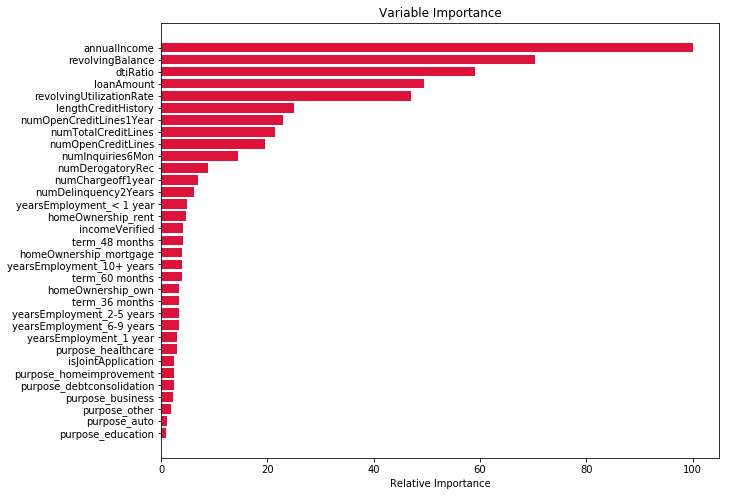

In [7]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_features = np.argsort(feature_importance)
pos = np.arange(sorted_features.shape[0]) + .5


plt.figure(figsize=(10,8))
plt.barh(pos, feature_importance[sorted_features], align='center', color='crimson')
plt.title('Variable Importance')
plt.xlabel('Relative Importance')

plt.yticks(pos, data.columns[sorted_features])

plt.show()

In [8]:
feature_importance_list=sorted(zip(clf.feature_importances_, feature_names), reverse=True)
output=pd.DataFrame(feature_importance_list)
output.columns=['Importance','Feature']
output = output[['Feature','Importance']]
output=output.style.format({
    'Importance': '{:,.2%}'.format
})
output

,Feature,Importance
0,annualIncome,19.48%
1,revolvingBalance,13.71%
2,dtiRatio,11.49%
3,loanAmount,9.64%
4,revolvingUtilizationRate,9.17%
5,lengthCreditHistory,4.89%
6,numOpenCreditLines1Year,4.46%
7,numTotalCreditLines,4.18%
8,numOpenCreditLines,3.81%
9,numInquiries6Mon,2.80%


In [9]:
feature_selected=[feature[1] for feature in feature_importance_list if (feature[0]>=0.01)]
pd.DataFrame(feature_selected,columns=["Feature Selected"])

,Feature Selected
0,annualIncome
1,revolvingBalance
2,dtiRatio
3,loanAmount
4,revolvingUtilizationRate
5,lengthCreditHistory
6,numOpenCreditLines1Year
7,numTotalCreditLines
8,numOpenCreditLines
9,numInquiries6Mon


## Correlation Analysis

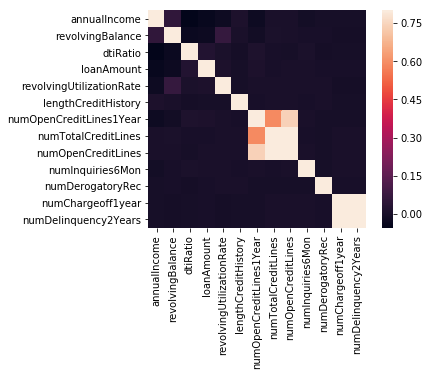

In [10]:
correlations = data[feature_selected].corr()
sns.heatmap(correlations, vmax=.8, square=True)
plt.show()

In [11]:
feature_selected.remove("numTotalCreditLines")
feature_selected.remove("numOpenCreditLines")
feature_selected.remove("numDelinquency2Years")
feature_selected

['annualIncome',
 'revolvingBalance',
 'dtiRatio',
 'loanAmount',
 'revolvingUtilizationRate',
 'lengthCreditHistory',
 'numOpenCreditLines1Year',
 'numInquiries6Mon',
 'numDerogatoryRec',
 'numChargeoff1year']

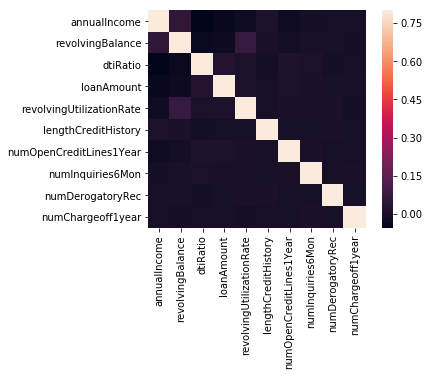

In [12]:
correlations = data[feature_selected].corr()
sns.heatmap(correlations, vmax=.8, square=True)
plt.show()

# Data Spliting

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

# Decison Tree

In [14]:
tree_param = {'criterion': ["gini","entropy"],
              'min_samples_split' : [50],
              'max_depth': [2, 5, 10]
             }
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier_best = GridSearchCV(estimator=tree_classifier, param_grid=tree_param, cv=5)

tree_classifier_best=tree_classifier_best.fit(X_train[feature_selected], y_train)

In [15]:
pd.DataFrame([tree_classifier_best.best_params_])

,criterion,max_depth,min_samples_split
0,gini,5,50


In [16]:
tree_classifier = tree.DecisionTreeClassifier(criterion='gini',max_depth=5,min_samples_split=50)
tree_classificator = tree_classifier.fit(X_train[feature_selected], y_train)
print(f"Score: {tree_classifier.score(X_test[feature_selected], y_test)}")

Score: 0.9037188189730563


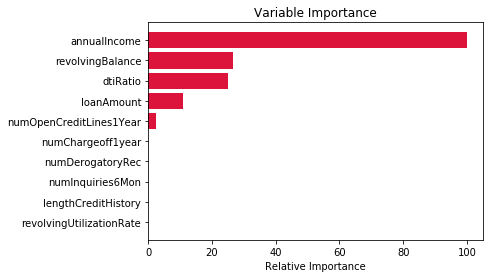

In [17]:
feature_importance = tree_classificator.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_features = np.argsort(feature_importance)
pos = np.arange(sorted_features.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_features], align='center', color='crimson')
plt.title('Variable Importance')
plt.xlabel('Relative Importance')

plt.yticks(pos, X_train[feature_selected].columns[sorted_features])

plt.show()

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()

rf_param = {'n_estimators': [10, 100, 200],
              'criterion' : ['gini'],
              'min_samples_split' : [50],
              'max_depth': [2, 5, 10]}

rf_best = GridSearchCV(estimator=rf, param_grid=rf_param, cv=5)
rf_best.fit(X_train[feature_selected], y_train)

pd.DataFrame([rf_best.best_params_])

,criterion,max_depth,min_samples_split,n_estimators
0,gini,10,50,200


In [19]:
rf = RandomForestClassifier(n_estimators=200,
              criterion='gini',
              min_samples_split=50,
              max_depth= 10)
rf=rf.fit(X_train[feature_selected], y_train)
print(f"Score: {rf.score(X_test[feature_selected], y_test)}")

Score: 0.9091325532003498


# Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
# from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train[feature_selected], y_train)
print(f"Score: {logreg.score(X_test[feature_selected], y_test)}")

Score: 0.89988756090451


# Deep Learning

In [21]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train[feature_selected])
X_train_scaled = X_scaler.transform(X_train[feature_selected])
X_test_scaled = X_scaler.transform(X_test[feature_selected])

from keras.utils import to_categorical

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

C:\Users\marce\Anaconda3\envs\MarceloEnvironment\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
from keras.models import Sequential
from keras.layers import Dense

deep = Sequential()
deep.add(Dense(units=10, activation='relu', input_dim=10))
deep.add(Dense(units=10, activation='relu'))
deep.add(Dense(units=10, activation='relu'))
deep.add(Dense(units=2, activation='softmax'))
deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the model
deep.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Fit the model to the training data
deep.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=0)

# Model Assessment

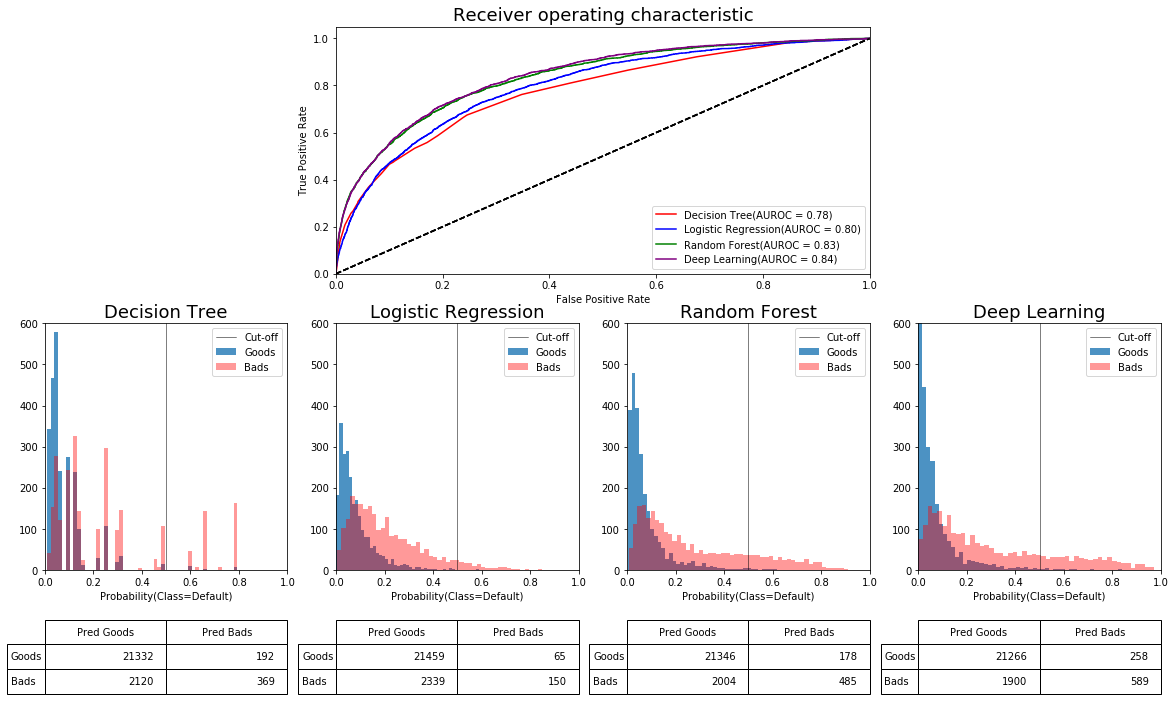

In [25]:
colors = ['red', 'blue', 'green','purple']

classifiers = [tree_classificator, logreg, rf, deep]
classifier_name = ['Decision Tree', 'Logistic Regression','Random Forest','Deep Learning']

plt.figure(figsize=(20,10))
ax=plt.subplot2grid((2, 4), (0, 1), colspan=2)
for i in range(0, len(classifiers)):
    classifier = classifiers[i]

    if i == 3:
        x_test = X_test_scaled
        y_pred = classifier.predict_classes(x_test)
    else:
        x_test = X_test[feature_selected]
        y_pred = classifier.predict(x_test)
        
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(x_test)[:,1])     
    roc_auc = auc(fpr, tpr)
    
    y_test_prob=list(zip(y_test,classifier.predict_proba(x_test)[:,1]))

    y_test_prob_goods=[i for i in y_test_prob if (i[0]==0)]
    y_test_prob_goods = random.sample(y_test_prob_goods,2489)
    y_test_prob_goods=np.array(y_test_prob_goods)
    y_test_prob_bads=[i for i in y_test_prob if (i[0]==1)]
    y_test_prob_bads=np.array(y_test_prob_bads)
    
    
    conf_matrix = confusion_matrix(y_test, y_pred).tolist()
    #conf_matrix = [np.concatenate([i,[sum(i)]]) for i in conf_matrix]
    #conf_matrix=list(zip(conf_matrix,[sum(conf_matrix[i,:]) for i in range(2)]))
    
    ax.plot(fpr, tpr, label=str(classifier_name[i]) + '(AUROC = %0.2f)' % roc_auc,color=colors[i])
    ax.plot([0, 1], [0, 1],'r--',color="black")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic',fontsize=18)
    ax.legend(loc="lower right")
    
    plt.subplot2grid((2, 4), (1, i), colspan=1)
    
    n_bins = 50

    x = y_test_prob_goods[:,1]
    y = y_test_prob_bads[:,1]

    plt.title(classifier_name[i],fontsize=18)
    plt.xlabel("Probability(Class=Default)")
    plt.hist(x, bins=n_bins,alpha=0.8)
    plt.hist(y, bins=n_bins,color="red",alpha=0.4)
    plt.ylim(0,600)
    plt.xlim(0,1)
    plt.axvline(x=0.5, ymin=0, linewidth=0.5, color='black')
    plt.legend(['Cut-off','Goods','Bads'])
    plt.table(cellText=conf_matrix,
      cellLoc='right', colWidths=None,
      rowLabels=['Goods','Bads'], rowColours=None, rowLoc='left',
      colLabels=['Pred Goods','Pred Bads'], colColours=None, colLoc='center',
      loc='bottom', bbox=[0, -0.5, 1, 0.3])

In [26]:
for i in range(0, len(classifiers)):
    classifier = classifiers[i]

    if i == 3:
        x_test = X_test_scaled
        y_pred = classifier.predict_classes(x_test)
    else:
        x_test = X_test[feature_selected]
        y_pred = classifier.predict(x_test)
        
    print('-------------------------------------------------------')     
    print(classifier_name[i])
    print('-------------------------------------------------------')
    print('\n\nClassification Report\n', classification_report(y_test, y_pred))

-------------------------------------------------------
Decision Tree
-------------------------------------------------------


Classification Report
              precision    recall  f1-score   support

          0       0.91      0.99      0.95     21524
          1       0.66      0.15      0.24      2489

avg / total       0.88      0.90      0.88     24013

-------------------------------------------------------
Logistic Regression
-------------------------------------------------------


Classification Report
              precision    recall  f1-score   support

          0       0.90      1.00      0.95     21524
          1       0.70      0.06      0.11      2489

avg / total       0.88      0.90      0.86     24013

-------------------------------------------------------
Random Forest
-------------------------------------------------------


Classification Report
              precision    recall  f1-score   support

          0       0.91      0.99      0.95     21524
    

# Save the Models

In [27]:
import pickle

# Decision Tree
with open('models/tree.pkl', 'wb') as fid:
    pickle.dump(tree_classificator, fid, 2)

# Logistic Regression
with open('models/logreg.pkl', 'wb') as fid:
    pickle.dump(logreg, fid, 2)
    
# Random Forest
with open('models/rf.pkl', 'wb') as fid:
    pickle.dump(rf, fid, 2)
    
# Neural Network
with open('models/neural.pkl', 'wb') as fid:
    pickle.dump(deep, fid, 2)
    
# X Scaler for Neural Network
with open('models/XScaler.pkl', 'wb') as fid:
    pickle.dump(X_scaler, fid, 2)

# Testing Flask Code

In [31]:
inputs = [[50000, 15000, 20, 20000, 50, 10, 7, 1, 1, 1]]

In [32]:
model_files = ['models/tree.pkl', 'models/logreg.pkl', 'models/rf.pkl', 'models/neural.pkl']
model_names = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'Neural Network']
outputs = []

for i in range(0, len(model_names)):
    pkl_file = open(model_files[i], 'rb')
    model = pickle.load(pkl_file)
    if model_names[i] == 'Neural Network':
        scaler = pickle.load(open('models/XScaler.pkl', 'rb'))
        inputs_scaled = scaler.transform(inputs)
        dict = {
            'Model': model_names[i],
            'Pred' : model.predict_classes(inputs_scaled)[0],
            'Prob' : "{:.2%}".format(model.predict_proba(inputs_scaled)[:,1][0])
        }
    else:
        dict = {
            'Model': model_names[i],
            'Pred' : model.predict(inputs)[0],
            'Prob' : "{:.2%}".format(model.predict_proba(inputs)[:,1][0])
        }
        
    if dict['Pred'] == 1:
        dict['Pred'] = "Default/Denied"
    else:
        dict['Pred'] = "Approved"
                        
    outputs.append(dict)
    
outputs

[{'Model': 'Decision Tree', 'Pred': 'Approved', 'Prob': '5.63%'},
 {'Model': 'Logistic Regression', 'Pred': 'Approved', 'Prob': '6.59%'},
 {'Model': 'Random Forest', 'Pred': 'Approved', 'Prob': '14.66%'},
 {'Model': 'Neural Network', 'Pred': 'Approved', 'Prob': '21.01%'}]